In [1]:
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from yellowbrick.classifier import ClassificationReport, ConfusionMatrix


import pandas as pd
import polars as pl

from matplotlib import pyplot

## TODO:

- check for information leakage/over fitting etc
- hyperparameter tuning
- more features
- feature importances
- combine prime/opt team results  for round predictor

In [2]:
df = pd.read_parquet('../data/raw/features.parquet', use_pandas_metadata=True)
df.columns

Index(['season', 'round', 'venue', 'date', 'prime_team', 'prime_team_points',
       'opt_team', 'opt_team_points', 'home_away', 'prime_margin', 'result',
       'prime_margin_1', 'prime_margin_2', 'prime_margin_3', 'prime_margin_4',
       'prime_margin_5', 'prime_margin_6', 'pm_l6w'],
      dtype='object')

In [3]:
df.tail()

,season,round,venue,date,prime_team,prime_team_points,opt_team,opt_team_points,home_away,prime_margin,result,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w
2043,2023,6,"Queensland Country Bank Stadium, Townsville",2023-04-07,Dolphins,32.0,Cowboys,22.0,away,10.0,1.0,-26.0,-26.0,-6.0,16.0,6.0,10.0,-4.333333
2044,2023,7,"Suncorp Stadium, Brisbane",2023-04-13,Dolphins,14.0,Rabbitohs,36.0,home,-22.0,-1.0,10.0,-26.0,-26.0,-6.0,16.0,6.0,-4.333333
2045,2023,8,"Suncorp Stadium, Brisbane",2023-04-23,Dolphins,28.0,Titans,26.0,home,2.0,1.0,-22.0,10.0,-26.0,-26.0,-6.0,16.0,-9.000000
2046,2023,9,"McDonalds Park, Wagga Wagga",2023-04-29,Dolphins,30.0,Raiders,31.0,away,-1.0,-1.0,2.0,-22.0,10.0,-26.0,-26.0,-6.0,-11.333333
2047,2023,10,"Suncorp Stadium, Brisbane",2023-05-06,Dolphins,36.0,Sharks,16.0,away,20.0,1.0,-1.0,2.0,-22.0,10.0,-26.0,-26.0,-10.500000


In [4]:
df.dtypes

season                  int64
round                   int64
venue                category
date                   object
prime_team           category
prime_team_points     float64
opt_team             category
opt_team_points       float64
home_away            category
prime_margin          float64
result                float64
prime_margin_1        float64
prime_margin_2        float64
prime_margin_3        float64
prime_margin_4        float64
prime_margin_5        float64
prime_margin_6        float64
pm_l6w                float64
dtype: object

In [5]:
y_cols = 'result'
X_cols = ['prime_team', 'home_away', 'opt_team', 'venue', 'prime_margin_1', 'prime_margin_2', 'prime_margin_3', 
          'prime_margin_4', 'prime_margin_5', 'prime_margin_6', 'pm_l6w']

In [6]:
history_df=df.loc[(df.result!=0) & ~df.result.isna(), :] # drop out the two draws, we're not trying to predict those so lets keep this binary
categories = {-1: 0, 1:1}

In [7]:
history_df

,season,round,venue,date,prime_team,prime_team_points,opt_team,opt_team_points,home_away,prime_margin,result,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w
0,2018,1,"Optus Stadium, Perth",2018-03-10,Rabbitohs,20.0,Warriors,32.0,home,-12.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018,2,"Panthers Stadium, Penrith",2018-03-17,Rabbitohs,14.0,Panthers,18.0,away,-4.0,-1.0,-12.0,NaN,NaN,NaN,NaN,NaN,-12.000000
2,2018,3,"Stadium Australia, Sydney",2018-03-24,Rabbitohs,34.0,Sea Eagles,6.0,home,28.0,1.0,-4.0,-12.0,NaN,NaN,NaN,NaN,-8.000000
3,2018,4,"Stadium Australia, Sydney",2018-03-30,Rabbitohs,20.0,Bulldogs,16.0,home,4.0,1.0,28.0,-4.0,-12.0,NaN,NaN,NaN,4.000000
4,2018,5,"Netstrata Jubilee Stadium, Sydney",2018-04-06,Rabbitohs,12.0,Dragons,16.0,away,-4.0,-1.0,4.0,28.0,-4.0,-12.0,NaN,NaN,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,2023,6,"Queensland Country Bank Stadium, Townsville",2023-04-07,Dolphins,32.0,Cowboys,22.0,away,10.0,1.0,-26.0,-26.0,-6.0,16.0,6.0,10.0,-4.333333
2044,2023,7,"Suncorp Stadium, Brisbane",2023-04-13,Dolphins,14.0,Rabbitohs,36.0,home,-22.0,-1.0,10.0,-26.0,-26.0,-6.0,16.0,6.0,-4.333333
2045,2023,8,"Suncorp Stadium, Brisbane",2023-04-23,Dolphins,28.0,Titans,26.0,home,2.0,1.0,-22.0,10.0,-26.0,-26.0,-6.0,16.0,-9.000000
2046,2023,9,"McDonalds Park, Wagga Wagga",2023-04-29,Dolphins,30.0,Raiders,31.0,away,-1.0,-1.0,2.0,-22.0,10.0,-26.0,-26.0,-6.0,-11.333333


In [8]:
X_df = history_df.loc[:, X_cols]
y_df = history_df.loc[:, y_cols]
y_df = y_df.replace(categories)

In [9]:
seed = 10
test_size = 0.33

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=test_size, random_state=seed)
#eval_set = [(X_test, y_test)]
eval_set = [(X_train, y_train), (X_test,y_test)]

[0]	validation_0-error:0.26401	validation_1-error:0.41317
[1]	validation_0-error:0.25000	validation_1-error:0.39671
[2]	validation_0-error:0.23451	validation_1-error:0.35778
[3]	validation_0-error:0.24041	validation_1-error:0.36228
[4]	validation_0-error:0.23156	validation_1-error:0.37575
[5]	validation_0-error:0.23230	validation_1-error:0.36976
[6]	validation_0-error:0.22788	validation_1-error:0.36527
[7]	validation_0-error:0.21976	validation_1-error:0.36826
[8]	validation_0-error:0.23451	validation_1-error:0.36228
[9]	validation_0-error:0.22566	validation_1-error:0.35928
[10]	validation_0-error:0.22788	validation_1-error:0.36377
[11]	validation_0-error:0.22419	validation_1-error:0.35629
[12]	validation_0-error:0.23304	validation_1-error:0.35030
[13]	validation_0-error:0.22050	validation_1-error:0.35778
[14]	validation_0-error:0.22345	validation_1-error:0.35629
[15]	validation_0-error:0.21903	validation_1-error:0.35479
[16]	validation_0-error:0.21976	validation_1-error:0.35629
[17]	va

/home/chris/miniconda3/envs/datasci/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


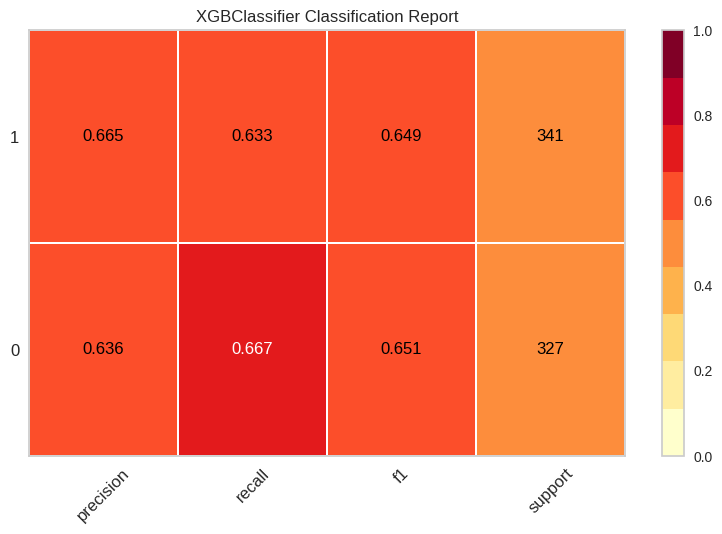

<Axes: title={'center': 'XGBClassifier Classification Report'}>

In [10]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
clf = XGBClassifier(tree_method="hist", 
                    #booster='dart',
                    enable_categorical=True, 
                    eval_metric="error",
                    early_stopping_rounds=15, 
                    n_estimators=30, 
                    learning_rate=0.1, 
                    gamma=6,
                    eta=0.01,
                    max_depth=8,
                    verbosity=1, 
                    subsample=0.9,
                    #colsample_bytree=0.9,
                    #colsample_bynode=0.9
                   )


# X is the dataframe we created in previous snippet
clf.fit(X_train, y_train,  
        eval_set=eval_set, 
        verbose=True, )


#clf = GaussianNB()
cr = ClassificationReport(clf, classes=[0,1], support=True, is_fitted=True)
cr.score(X_test, y_test)        # Evaluate the model on the test data
cr.show()                       # Finalize and show the figure

/home/chris/miniconda3/envs/datasci/lib/python3.11/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


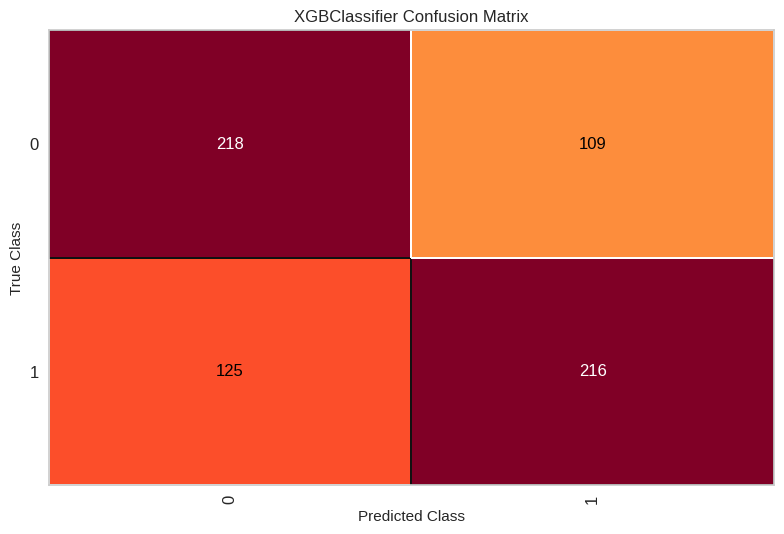

<Axes: title={'center': 'XGBClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [11]:
cm = ConfusionMatrix(clf, classes=[0,1], is_fitted=True)
# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()


In [12]:
predictions = clf.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 64.97%


In [14]:
f1 = f1_score(y_test, predictions)
print("F1: %.2f%%" % (f1 * 100.0))

F1: 64.86%


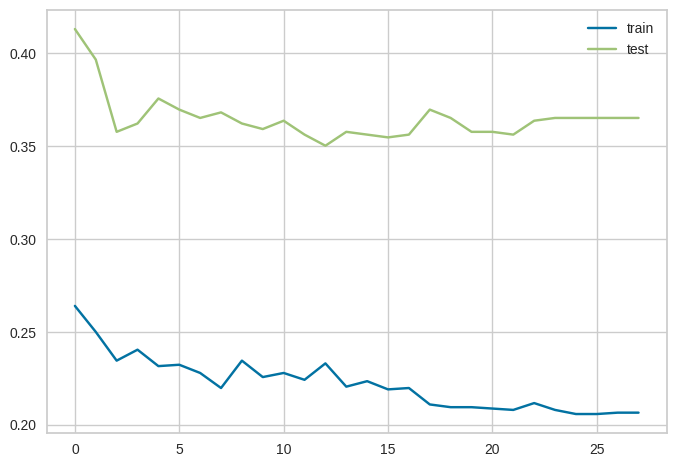

In [15]:
results = clf.evals_result()
# plot learning curves
pyplot.plot(results['validation_0']['error'], label='train')
pyplot.plot(results['validation_1']['error'], label='test')
# show the legend
pyplot.legend()
#pyplot.ylim(0,0.4)
# show the plot
pyplot.show()

In [16]:
df.sort_values('date')

,season,round,venue,date,prime_team,prime_team_points,opt_team,opt_team_points,home_away,prime_margin,result,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w
892,2018,1,"Netstrata Jubilee Stadium, Sydney",2018-03-08,Broncos,12.0,Dragons,34.0,away,-22.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1656,2018,1,"Netstrata Jubilee Stadium, Sydney",2018-03-08,Dragons,34.0,Broncos,12.0,home,22.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1147,2018,1,"1300SMILES Stadium, Townsville",2018-03-09,Cowboys,20.0,Sharks,14.0,home,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
383,2018,1,"McDonald Jones Stadium, Newcastle",2018-03-09,Knights,19.0,Sea Eagles,18.0,home,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1529,2018,1,"1300SMILES Stadium, Townsville",2018-03-09,Sharks,14.0,Cowboys,20.0,away,-6.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,2023,11,"Accor Stadium, Sydney",2023-05-13,Rabbitohs,NaN,Wests Tigers,NaN,home,NaN,NaN,16.0,26.0,2.0,22.0,34.0,-8.0,15.333333
1655,2023,11,"4 Pines Park, Sydney",2023-05-14,Sharks,NaN,Sea Eagles,NaN,away,NaN,NaN,-20.0,38.0,13.0,10.0,-2.0,-2.0,6.166667
635,2023,11,"McDonald Jones Stadium, Newcastle",2023-05-14,Titans,NaN,Knights,NaN,away,NaN,NaN,2.0,16.0,-2.0,-17.0,2.0,-12.0,-1.833333
1909,2023,11,"4 Pines Park, Sydney",2023-05-14,Sea Eagles,NaN,Sharks,NaN,home,NaN,NaN,-26.0,-16.0,6.0,10.0,-32.0,0.0,-9.666667


In [19]:
nr_pred=clf.predict(df.loc[(df.season==2023) & 
                   (df['round']==11), X_cols])
nr_pred_proba=clf.predict_proba(df.loc[(df.season==2023) & 
                                       (df['round']==11), X_cols])

In [20]:
nr_pred

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1])

In [21]:
next_round = df.loc[(df.season==2023) & 
       (df['round']==11), X_cols]

In [22]:
next_round.assign(pred = nr_pred).assign(pred_proba_0 = nr_pred_proba[:, 0], pred_proba_1=nr_pred_proba[:, 1]).sort_values(['venue'])

,prime_team,home_away,opt_team,venue,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w,pred,pred_proba_0,pred_proba_1
382,Storm,home,Broncos,"AAMI Park, Melbourne",-16.0,8.0,-10.0,20.0,8.0,8.0,3.000000,1,0.358872,0.641128
1019,Broncos,away,Storm,"AAMI Park, Melbourne",26.0,-26.0,10.0,17.0,-6.0,34.0,9.166667,0,0.683256,0.316744
509,Knights,home,Titans,"McDonald Jones Stadium, Newcastle",-31.0,-2.0,-1.0,10.0,0.0,0.0,-4.000000,1,0.419433,0.580567
635,Titans,away,Knights,"McDonald Jones Stadium, Newcastle",2.0,16.0,-2.0,-17.0,2.0,-12.0,-1.833333,1,0.479699,0.520301
763,Eels,away,Raiders,"GIO Stadium, Canberra",-2.0,31.0,-10.0,26.0,6.0,-8.0,7.166667,1,0.359073,0.640927
1401,Raiders,home,Eels,"GIO Stadium, Canberra",4.0,1.0,6.0,6.0,-41.0,-41.0,-10.833333,1,0.362556,0.637444
127,Rabbitohs,home,Wests Tigers,"Accor Stadium, Sydney",16.0,26.0,2.0,22.0,34.0,-8.0,15.333333,1,0.278379,0.721621
255,Warriors,away,Bulldogs,"Accor Stadium, Sydney",-12.0,-14.0,-8.0,8.0,-10.0,2.0,-5.666667,1,0.465227,0.534773
891,Bulldogs,home,Warriors,"Accor Stadium, Sydney",-4.0,2.0,-13.0,-26.0,-34.0,1.0,-12.333333,0,0.542243,0.457757
1146,Wests Tigers,away,Rabbitohs,"Accor Stadium, Sydney",2.0,4.0,-6.0,-6.0,-34.0,-34.0,-12.333333,0,0.727670,0.272330


In [23]:
next_round

,prime_team,home_away,opt_team,venue,prime_margin_1,prime_margin_2,prime_margin_3,prime_margin_4,prime_margin_5,prime_margin_6,pm_l6w
127,Rabbitohs,home,Wests Tigers,"Accor Stadium, Sydney",16.0,26.0,2.0,22.0,34.0,-8.0,15.333333
255,Warriors,away,Bulldogs,"Accor Stadium, Sydney",-12.0,-14.0,-8.0,8.0,-10.0,2.0,-5.666667
382,Storm,home,Broncos,"AAMI Park, Melbourne",-16.0,8.0,-10.0,20.0,8.0,8.0,3.000000
509,Knights,home,Titans,"McDonald Jones Stadium, Newcastle",-31.0,-2.0,-1.0,10.0,0.0,0.0,-4.000000
635,Titans,away,Knights,"McDonald Jones Stadium, Newcastle",2.0,16.0,-2.0,-17.0,2.0,-12.0,-1.833333
763,Eels,away,Raiders,"GIO Stadium, Canberra",-2.0,31.0,-10.0,26.0,6.0,-8.0,7.166667
891,Bulldogs,home,Warriors,"Accor Stadium, Sydney",-4.0,2.0,-13.0,-26.0,-34.0,1.0,-12.333333
1019,Broncos,away,Storm,"AAMI Park, Melbourne",26.0,-26.0,10.0,17.0,-6.0,34.0,9.166667
1146,Wests Tigers,away,Rabbitohs,"Accor Stadium, Sydney",2.0,4.0,-6.0,-6.0,-34.0,-34.0,-12.333333
1274,Cowboys,home,Dragons,"Queensland Country Bank Stadium, Townsville",14.0,-38.0,2.0,-8.0,-10.0,-1.0,-6.833333
